In [1]:
import pennylane as qml

from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras

import time

from itertools import product
from itertools import combinations_with_replacement

In [2]:
### Parameters


# 1) Pennylane

qml_device_types = ["lightning.gpu", "default.qubit"]


# 2) Image

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28


# 3) Filters

MIN_FILTER_WIDTH = 1
MAX_FILTER_WIDTH = 15

MIN_FILTER_HEIGHT = 2
MAX_FILTER_HEIGHT = 2

MIN_FILTERS_COUNT = 1
MAX_FILTERS_COUNT = 1

RANDOM_LAYERS_COUNT = 1


# 4) Strides

MIN_STRIDE_WIDTH = 28
MAX_STRIDE_WIDTH = 28

MIN_STRIDE_HEIGHT = 28
MAX_STRIDE_HEIGHT = 28


# 5) Seeds

np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# CUDA Devices

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0, 1, 2, 3"

In [4]:
def get_combinations(widths, heights):    
   
    sizes = []
    
    for width in widths:
        for height in heights:
            
            size = (width, height)
            reversed_size = (height, width)
                           
            if reversed_size in sizes:
                continue
                
            sizes.append(size)    
   
    sorted_sizes = tuple(sorted(sizes))    

    return sorted_sizes

In [5]:
def parse_image(image_size, filter_size, stride_size):
    
    image_width, image_height = image_size    
    filter_width, filter_height = filter_size
    stride_width, stride_height = stride_size
        
    filter_surface = filter_width * filter_height
    
    
    # Repetition counts
    
    if stride_width >= filter_width:
        
        horizontal_filter_repetitions = image_width // stride_width        
        horizontal_filter_repetitions += (image_width % stride_width) // filter_width  
        
    else:
        
        horizontal_filter_repetitions = (image_width - filter_width + 1) // stride_width  

        
    if stride_height >= filter_height:
        
        vertical_filter_repetitions = image_height // stride_height        
        vertical_filter_repetitions += (image_height % stride_height) // filter_height
        
    else:
 
        vertical_filter_repetitions = (image_height - filter_height + 1) // stride_height 
        

    complexity = (2 ** filter_surface
                  * filters_count
                  * horizontal_filter_repetitions 
                  * vertical_filter_repetitions) 

    result = {"filter_width": filter_width, 
              "filter_height": filter_height,
              "filter_surface": filter_surface,
              "filters_count": filters_count,

              "stride_width": stride_width,
              "stride_height": stride_height,                      
              
              "horizontal_filter_repetitions": horizontal_filter_repetitions,
              "vertical_filter_repetitions": vertical_filter_repetitions,

              "complexity": complexity}
    
    return result

In [6]:
### Quanvolution

def filter_circuit(pixel_values, random_layer_parameters, qubits):    

    for qubit, pixel_value in enumerate(pixel_values):      

        theta = np.pi * pixel_value        
        qml.RY(theta, wires=qubit)        

    RandomLayers(random_layer_parameters, wires=qubits)

    measurement_result = [qml.expval(qml.PauliZ(qubit)) for qubit in qubits]

    return measurement_result


def quanvolve(image, image_size, filter_size, stride_size, 
              channel_count, random_layer_parameters, qubits,
              bound_filter_circuit):
    
    """Convolve input image with many applications of the same quantum kernel circuit."""
    
    image_width, image_height = image_size
    
    parsed_image = parse_image(image_size, filter_size, stride_size)
    
    filter_width = parsed_image['filter_width']
    filter_height = parsed_image['filter_height']

    stride_width = experiment['stride_width']
    stride_height = experiment['stride_height']
    
    # stride_size = (stride_width, stride_height)
    
    feature_width = horizontal_filter_repetitions = parsed_image['horizontal_filter_repetitions']    
    feature_height = vertical_filter_repetitions = parsed_image['vertical_filter_repetitions']

    features = np.zeros((feature_width, feature_height, channel_count))

    deltas = list(product(range(filter_width),
                          range(filter_height)))
    
    # Loop over image
    
    for feature_x, image_corner_x in enumerate(range(horizontal_filter_repetitions)):
        for feature_y, image_corner_y in enumerate(range(vertical_filter_repetitions)):   

            pixel_values = []

            for x_delta, y_delta in deltas:

                x = image_corner_x + x_delta
                y = image_corner_y + y_delta                
               
                pixel_values.append(np.squeeze(image[x, y]))

            # Call filter

            filter_outputs = bound_filter_circuit(pixel_values, 
                                                  random_layer_parameters, 
                                                  qubits)

            # Feature outputs

            for channel, filter_output in enumerate(filter_outputs):

                features[feature_x, feature_y, channel] = filter_output            

    return features

In [7]:
def run_experiment(experiment_id, experiment):    
  
    print(f"\n===================")
    
    display(f"Experiment: {experiment_id}", experiment)
    
    print("\nQuantum pre-processing of image...") 
    
    
    # Inintialize
    
    start_time = time.time()
    
    filter_width = experiment['filter_width']
    filter_height = experiment['filter_height']
    
    filter_size = (filter_width, filter_height)
    
    filters_count = experiment['filters_count']

    stride_width = experiment['stride_width']
    stride_height = experiment['stride_height']
    
    stride_size = (stride_width, stride_height)
    
    feature_width = experiment['horizontal_filter_repetitions']    
    feature_height = experiment['vertical_filter_repetitions']
    
    channels_count = qubits_count = filter_surface = filter_width * filter_height
    
    qubits = list(range(qubits_count))
    
    device_type = experiment['device_type']
    
    qml_device = qml.device(device_type, wires=qubits_count)
  
    
    filter_outputs = []
    
    for _ in range(filters_count):  
        
        # Circuit

        bound_filter_circuit = qml.QNode(filter_circuit, qml_device)
        
        random_layer_parameters = np.random.uniform(high=2*np.pi,
                                                    size=(RANDOM_LAYERS_COUNT, 
                                                          channels_count)) 
        
        # Quanvolve
        
        filter_output = quanvolve(one_image, image_size, filter_size, stride_size, 
                                  channels_count, random_layer_parameters, qubits,
                                  bound_filter_circuit)
        
        filter_outputs.append(filter_output)
        
        # print(filter_output)       
        
    
    # Time
    
    execution_time = time.time() - start_time
    
    experiments[experiment_id]['execution_time'] = execution_time

    print(f"\nExecution time: {execution_time:.2f} seconds")

In [8]:
### ### Secondary parameter calculation

# 1) Pennylane

# -


# 2) Image

image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)


# 3) Filters

max_filter_width = min(MAX_FILTER_WIDTH + 1, IMAGE_WIDTH + 1)
max_filter_height = min(MAX_FILTER_HEIGHT + 1, IMAGE_HEIGHT + 1)

filter_widths = list(range(MIN_FILTER_WIDTH, max_filter_width))
filter_heights = list(range(MIN_FILTER_HEIGHT, max_filter_height))

filter_sizes = get_combinations(filter_widths, filter_heights)

filter_counts = range(MIN_FILTERS_COUNT, MAX_FILTERS_COUNT + 1)

filter_combinations = list(product(filter_sizes, filter_counts))


# 4) Strides

stride_widths = range(MIN_STRIDE_WIDTH, MAX_STRIDE_WIDTH + 1)
stride_heights = range(MIN_STRIDE_HEIGHT, MAX_STRIDE_HEIGHT + 1)

strides = get_combinations(stride_widths, stride_heights)


# 5) Seeds

# -

In [9]:
# Load MNIST dataset

mnist_dataset = keras.datasets.mnist
train_data, test_data = mnist_dataset.load_data()

train_images, train_labels = train_data
test_images, test_labels = test_data

# Normalize pixels

train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels

train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

one_image = train_images[0]

In [10]:
# Prepare experiments


experiment_list = []

for filter_size, filters_count in filter_combinations:
 
    for stride_size in strides:   
        
        experiment = parse_image(image_size, filter_size, stride_size)
   
        experiment_list.append(experiment)    
    
sorted_experiments = sorted(experiment_list, 
                            key=lambda experiment: experiment['complexity'])

sorted_experiments_with_devices = [{**experiment, 'device_type': device_type}
                                   for device_type in qml_device_types
                                   for experiment in sorted_experiments]

experiments = dict(enumerate(sorted_experiments_with_devices))

# print(experiments)

In [11]:
len(experiments)

30

In [12]:
# Run experiments

for experiment_id, experiment in experiments.items():
    
    if 'execution_time' not in experiment:
    
        run_experiment(experiment_id, experiment)

'Experiment: 0'

{'filter_width': 1,
 'filter_height': 2,
 'filter_surface': 2,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 4,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 1.62 seconds



'Experiment: 1'

{'filter_width': 2,
 'filter_height': 2,
 'filter_surface': 4,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 16,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 0.01 seconds



'Experiment: 2'

{'filter_width': 3,
 'filter_height': 2,
 'filter_surface': 6,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 64,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 0.01 seconds



'Experiment: 3'

{'filter_width': 4,
 'filter_height': 2,
 'filter_surface': 8,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 256,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 0.01 seconds



'Experiment: 4'

{'filter_width': 5,
 'filter_height': 2,
 'filter_surface': 10,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 1024,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 0.01 seconds



'Experiment: 5'

{'filter_width': 6,
 'filter_height': 2,
 'filter_surface': 12,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 4096,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 0.01 seconds



'Experiment: 6'

{'filter_width': 7,
 'filter_height': 2,
 'filter_surface': 14,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 16384,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 0.01 seconds



'Experiment: 7'

{'filter_width': 8,
 'filter_height': 2,
 'filter_surface': 16,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 65536,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 0.01 seconds



'Experiment: 8'

{'filter_width': 9,
 'filter_height': 2,
 'filter_surface': 18,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 262144,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 0.02 seconds



'Experiment: 9'

{'filter_width': 10,
 'filter_height': 2,
 'filter_surface': 20,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 1048576,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 0.05 seconds



'Experiment: 10'

{'filter_width': 11,
 'filter_height': 2,
 'filter_surface': 22,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 4194304,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 0.19 seconds



'Experiment: 11'

{'filter_width': 12,
 'filter_height': 2,
 'filter_surface': 24,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 16777216,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 0.74 seconds



'Experiment: 12'

{'filter_width': 13,
 'filter_height': 2,
 'filter_surface': 26,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 67108864,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 3.46 seconds



'Experiment: 13'

{'filter_width': 14,
 'filter_height': 2,
 'filter_surface': 28,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 268435456,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 14.29 seconds



'Experiment: 14'

{'filter_width': 15,
 'filter_height': 2,
 'filter_surface': 30,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 1073741824,
 'device_type': 'lightning.gpu'}


Quantum pre-processing of image...

Execution time: 47.56 seconds



'Experiment: 15'

{'filter_width': 1,
 'filter_height': 2,
 'filter_surface': 2,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 4,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 0.01 seconds



'Experiment: 16'

{'filter_width': 2,
 'filter_height': 2,
 'filter_surface': 4,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 16,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 0.01 seconds



'Experiment: 17'

{'filter_width': 3,
 'filter_height': 2,
 'filter_surface': 6,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 64,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 0.02 seconds



'Experiment: 18'

{'filter_width': 4,
 'filter_height': 2,
 'filter_surface': 8,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 256,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 0.02 seconds



'Experiment: 19'

{'filter_width': 5,
 'filter_height': 2,
 'filter_surface': 10,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 1024,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 0.02 seconds



'Experiment: 20'

{'filter_width': 6,
 'filter_height': 2,
 'filter_surface': 12,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 4096,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 0.03 seconds



'Experiment: 21'

{'filter_width': 7,
 'filter_height': 2,
 'filter_surface': 14,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 16384,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 0.04 seconds



'Experiment: 22'

{'filter_width': 8,
 'filter_height': 2,
 'filter_surface': 16,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 65536,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 0.09 seconds



'Experiment: 23'

{'filter_width': 9,
 'filter_height': 2,
 'filter_surface': 18,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 262144,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 0.23 seconds



'Experiment: 24'

{'filter_width': 10,
 'filter_height': 2,
 'filter_surface': 20,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 1048576,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 1.10 seconds



'Experiment: 25'

{'filter_width': 11,
 'filter_height': 2,
 'filter_surface': 22,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 4194304,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 5.72 seconds



'Experiment: 26'

{'filter_width': 12,
 'filter_height': 2,
 'filter_surface': 24,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 16777216,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 26.05 seconds



'Experiment: 27'

{'filter_width': 13,
 'filter_height': 2,
 'filter_surface': 26,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 67108864,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...

Execution time: 113.68 seconds



'Experiment: 28'

{'filter_width': 14,
 'filter_height': 2,
 'filter_surface': 28,
 'filters_count': 1,
 'stride_width': 28,
 'stride_height': 28,
 'horizontal_filter_repetitions': 1,
 'vertical_filter_repetitions': 1,
 'complexity': 268435456,
 'device_type': 'default.qubit'}


Quantum pre-processing of image...


KeyboardInterrupt: 

In [123]:
# Aggregate execution times

from collections import defaultdict


execution_times = defaultdict(lambda: defaultdict(list))

for experiment_id, experiment in experiments.items():
    
    if 'execution_time' not in experiment:
        continue
    
    device_type = experiment['device_type']
    qubit_count = experiment['filter_surface']
    execution_time = experiment['execution_time']
    
    execution_times[device_type]['qubit_count'].append(qubit_count)
    execution_times[device_type]['execution_time'].append(execution_time)

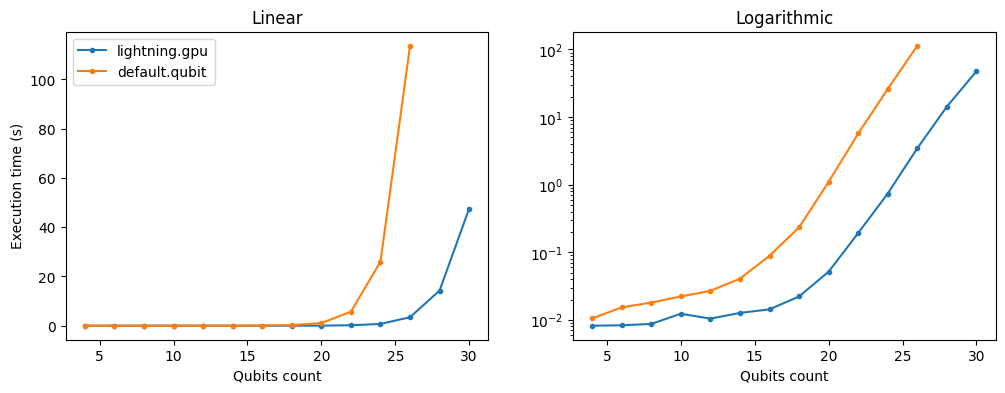

In [124]:
# Visualize

from matplotlib import pyplot as plt


figure, (linear, logarithmic) = plt.subplots(1, 2, figsize=(12, 4))

for device_type in execution_times:
    
    qubit_count = execution_times[device_type]['qubit_count']
    execution_time = execution_times[device_type]['execution_time']

    linear.plot(qubit_count[1:], 
                execution_time[1:], 
                '.-', label=device_type)
    
    logarithmic.plot(qubit_count[1:], 
                     execution_time[1:], 
                     '.-', label=device_type)
    
linear.set_title("Linear")
linear.set_ylabel("Execution time (s)")
linear.set_xlabel("Qubits count")
linear.legend()

logarithmic.set_title("Logarithmic")
logarithmic.set_xlabel("Qubits count")
logarithmic.set_yscale("log")

plt.show()